# 네이버 영화리뷰 감성분석

한국어 텍스트의 감정분석을 진행합니다.  
이번에 사용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)입니다.

## 1. 데이터 준비

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

from konlpy.tag import Mecab
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any')  # NA값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any')  # NA값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [7]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [8]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [9]:
# {텍스트: 인덱스}에서 {인덱스:텍스트}로 변경

index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공

In [11]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [12]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 지정 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [14]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

## 모델구성 및 validation set 구성

In [15]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 41 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

## 1) GlobalMaxPooling

In [16]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d (Global (None, 41)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


## 2) LSTM

In [17]:
model2 = keras.Sequential(name='LSTM')
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


## 3) Convolution Neural Network

In [18]:
model3 = keras.Sequential(name='CNN')
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(keras.layers.MaxPooling1D(5))
model3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9       

In [19]:
# validation set 구성

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.2,
                                                          random_state=7)

## 모델 훈련 개시

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [21]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 9ms/step - loss: 0.6199 - accuracy: 0.7406 - val_loss: 0.3871 - val_accuracy: 0.8310
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3449 - accuracy: 0.8533 - val_loss: 0.3577 - val_accuracy: 0.8442
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2938 - accuracy: 0.8791 - val_loss: 0.3561 - val_accuracy: 0.8480
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2614 - accuracy: 0.8943 - val_loss: 0.3615 - val_accuracy: 0.8477
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2349 - accuracy: 0.9073 - val_loss: 0.3727 - val_accuracy: 0.8467
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2128 - accuracy: 0.9183 - val_loss: 0.3878 - val_accuracy: 0.8444
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.1867 - accuracy: 0.9298 - val_loss: 0.4034 - val_accuracy: 0.8433
Epoch 

In [22]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 6s 14ms/step - loss: 0.5918 - accuracy: 0.7100 - val_loss: 0.3735 - val_accuracy: 0.8411
Epoch 2/20
229/229 [==============================] - 3s 12ms/step - loss: 0.3374 - accuracy: 0.8597 - val_loss: 0.3661 - val_accuracy: 0.8431
Epoch 3/20
229/229 [==============================] - 3s 13ms/step - loss: 0.3142 - accuracy: 0.8710 - val_loss: 0.3641 - val_accuracy: 0.8467
Epoch 4/20
229/229 [==============================] - 3s 12ms/step - loss: 0.2968 - accuracy: 0.8796 - val_loss: 0.3649 - val_accuracy: 0.8441
Epoch 5/20
229/229 [==============================] - 3s 13ms/step - loss: 0.2854 - accuracy: 0.8848 - val_loss: 0.3652 - val_accuracy: 0.8438
Epoch 6/20
229/229 [==============================] - 3s 13ms/step - loss: 0.2778 - accuracy: 0.8881 - val_loss: 0.3660 - val_accuracy: 0.8457
Epoch 7/20
229/229 [==============================] - 3s 12ms/step - loss: 0.2667 - accuracy: 0.8954 - val_loss: 0.3657 - val_accuracy: 0.8468

In [23]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 11s 30ms/step - loss: 0.5870 - accuracy: 0.6743 - val_loss: 0.3617 - val_accuracy: 0.8437
Epoch 2/20
229/229 [==============================] - 3s 11ms/step - loss: 0.3178 - accuracy: 0.8660 - val_loss: 0.3480 - val_accuracy: 0.8503
Epoch 3/20
229/229 [==============================] - 2s 11ms/step - loss: 0.2742 - accuracy: 0.8874 - val_loss: 0.3453 - val_accuracy: 0.8528
Epoch 4/20
229/229 [==============================] - 2s 11ms/step - loss: 0.2333 - accuracy: 0.9086 - val_loss: 0.3601 - val_accuracy: 0.8517
Epoch 5/20
229/229 [==============================] - 2s 11ms/step - loss: 0.1901 - accuracy: 0.9298 - val_loss: 0.3908 - val_accuracy: 0.8456
Epoch 6/20
229/229 [==============================] - 2s 11ms/step - loss: 0.1458 - accuracy: 0.9499 - val_loss: 0.4428 - val_accuracy: 0.8439
Epoch 7/20
229/229 [==============================] - 3s 11ms/step - loss: 0.1075 - accuracy: 0.9654 - val_loss: 0.4974 - val_accuracy: 0.836

In [24]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
results2 = model2.evaluate(X_test,  y_test, verbose=2)
results3 = model3.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.5461 - accuracy: 0.8309
1537/1537 - 5s - loss: 0.3949 - accuracy: 0.8430
1537/1537 - 5s - loss: 0.8415 - accuracy: 0.8279


# Loss, Accuracy 그래프 시각화

In [25]:
import matplotlib.pyplot as plt

history1_dict = history1.history
history2_dict = history2.history
history3_dict = history3.history

print(history1_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

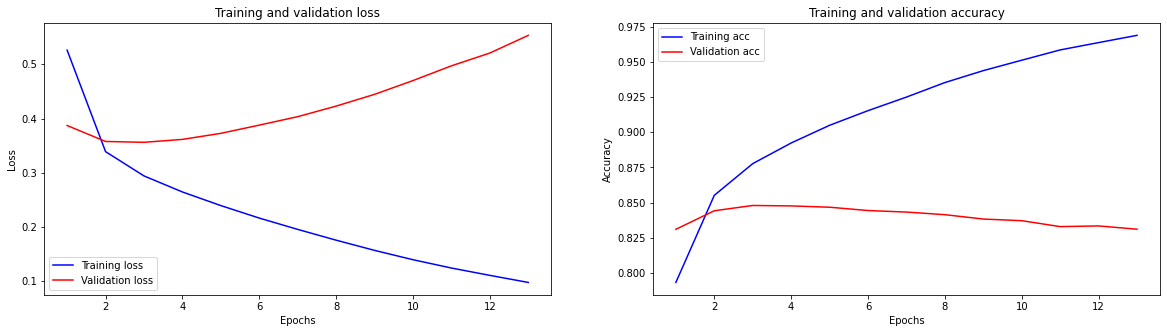

In [26]:
# GlobalMaxPooling1D 그래프

acc = history1_dict['accuracy']
val_acc = history1_dict['val_accuracy']
loss = history1_dict['loss']
val_loss = history1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

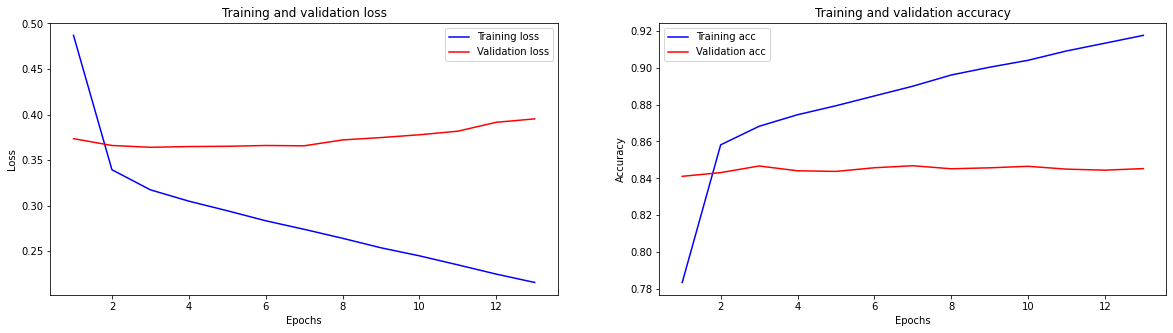

In [27]:
# LSTM 그래프

acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

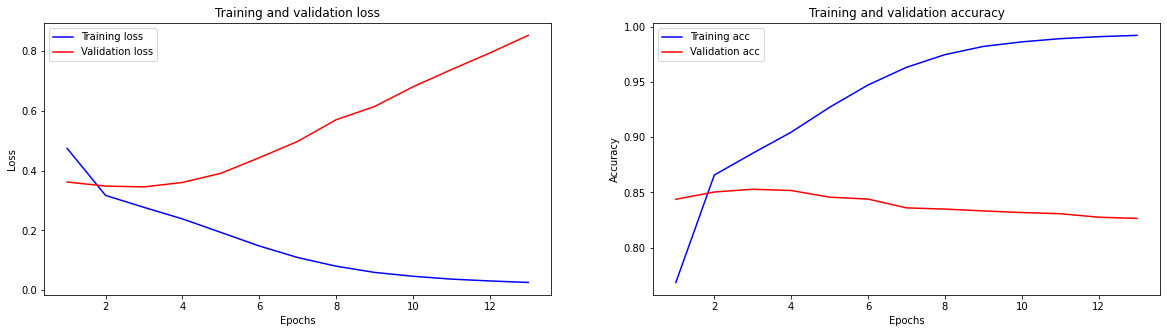

In [28]:
# CNN 그래프

acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

In [29]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [30]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['만족']
vector

array([-1.27514884e-01, -2.62219042e-01,  5.27439378e-02, -2.50130240e-02,
       -9.78279486e-02,  7.10882843e-02, -1.96538836e-01, -3.11686806e-02,
       -4.40386795e-02,  1.15061775e-01, -1.20470531e-01,  1.03324980e-01,
        1.18594393e-01, -9.34839845e-02,  1.56912401e-01, -6.66635577e-03,
        1.06173739e-01,  1.05865061e-01, -4.36652750e-02, -7.73522258e-02,
        1.96158158e-04, -1.01748854e-01,  9.47860032e-02, -1.31286494e-02,
       -5.18954024e-02, -4.96742781e-03, -1.24621607e-01, -6.55496567e-02,
        6.38611168e-02,  1.63148403e-01,  6.31174147e-02, -3.39026563e-02,
       -5.15533872e-02,  8.85749310e-02,  4.47758809e-02, -1.01761073e-01,
        5.56289777e-02, -2.10854951e-02, -6.27977476e-02,  9.69586661e-04,
       -1.64646491e-01], dtype=float32)

In [32]:
word_vectors.similar_by_word("놀람")

[('다스', 0.8133465051651001),
 ('캡', 0.8036590814590454),
 ('난생', 0.797137975692749),
 ('소망', 0.7957144379615784),
 ('울려', 0.7956303358078003),
 ('후세', 0.7953886389732361),
 ('김윤석', 0.7751271724700928),
 ('볼게요', 0.7751164436340332),
 ('슴다', 0.7722334861755371),
 ('겠다는', 0.7718525528907776)]

## 한국어 Word2Vec 임베딩 활용하여 성능개선

In [33]:
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

In [34]:
word2vec = Word2Vec.load(word2vec_path)

In [35]:
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [41]:
# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(keras.layers.LSTM(512))
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [42]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 36s 149ms/step - loss: 0.5244 - accuracy: 0.7296 - val_loss: 0.3730 - val_accuracy: 0.8340
Epoch 2/20
229/229 [==============================] - 34s 148ms/step - loss: 0.3242 - accuracy: 0.8592 - val_loss: 0.3375 - val_accuracy: 0.8510
Epoch 3/20
229/229 [==============================] - 34s 148ms/step - loss: 0.2696 - accuracy: 0.8867 - val_loss: 0.3259 - val_accuracy: 0.8634
Epoch 4/20
229/229 [==============================] - 34s 149ms/step - loss: 0.2284 - accuracy: 0.9060 - val_loss: 0.3395 - val_accuracy: 0.8621
Epoch 5/20
229/229 [==============================] - 34s 149ms/step - loss: 0.1850 - accuracy: 0.9265 - val_loss: 0.3602 - val_accuracy: 0.8642
Epoch 6/20
229/229 [==============================] - 34s 150ms/step - loss: 0.1401 - accuracy: 0.9448 - val_loss: 0.3891 - val_accuracy: 0.8579
Epoch 7/20
229/229 [==============================] - 34s 149ms/step - loss: 0.1052 - accuracy: 0.9584 - val_loss: 0.4500 - val_ac

In [43]:
results = model4.evaluate(X_test, y_test, verbose=2)

1537/1537 - 13s - loss: 0.7826 - accuracy: 0.8516
